# Plot Maps of Minimum or Maximum Temperature for a Given Hour by County


In [1]:
# Start by importing the packages we need:
import os
import glob
import warnings

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable


## Suppress Future Warnings


In [2]:
# Suppress future warnings:
warnings.simplefilter(action='ignore', category=FutureWarning)


## Set the Directory Structure

In [3]:
# Identify the data input and output directories:
hw_cs_data_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/data/thermal_events_data/'
weather_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs_V2/tell_data/wrf_tell_counties_output/'
nerc_shapefile_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/data/NERC_TPL08_shapefiles/'
county_shapefile_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/data/county_shapefiles/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/figures/case_study_results/'


## Process the Temperature Values by County for a Given Event


In [18]:
# Define a function to process the minimum, maximum, and mean temperatures by county for a given event:
def process_temperature_data(hw_cs: str, event: str, hw_cs_data_dir: str, weather_data_input_dir: str):
    
    if hw_cs == 'HW':
       # Read in the raw data from the heat wave library:
       library_df = pd.read_csv((hw_cs_data_dir + 'hw_library_expanded.csv'))
    elif hw_cs == 'CS':
       # Read in the raw data from the cold snap library:
       library_df = pd.read_csv((hw_cs_data_dir + 'cs_library_expanded.csv'))

    # Subset to just the data for definition you want to use:
    event_df = library_df[(library_df['UID'] == event)].copy()

    # Extract the start and end days and years:
    event_df['Start'] = pd.to_datetime(event_df['Start'])
    event_df['End'] = pd.to_datetime(event_df['End']) + pd.Timedelta(days=1)
    event_df['Start_Year'] = event_df['Start'].dt.year
    event_df['End_Year'] = event_df['End'].dt.year
    
    # Create a list of all county meteorology files in the input directory:
    if event_df['End_Year'].iloc[0] <= 2019:
       filelist_df = pd.DataFrame({'Filename': sorted(glob.glob(os.path.join(weather_data_input_dir, 'historic', str(event_df['Start_Year'].iloc[0]), '*.csv')))})
    else:
       filelist_df = pd.DataFrame({'Filename': sorted(glob.glob(os.path.join(weather_data_input_dir, 'historic_2020_2024', str(event_df['Start_Year'].iloc[0]), '*.csv')))}) 

    # Loop over the filelist and extract the time string from the filename:
    for row in range(len(filelist_df)):
        filename = filelist_df['Filename'].iloc[row]
        time_string = filename.split((str(event_df['Start_Year'].iloc[0]) + '/'))[1].rstrip('_UTC_County_Mean_Meteorology.csv')
        filelist_df.loc[row,'Time'] = pd.to_datetime(time_string, format='%Y_%m_%d_%H')
        
    # Subset to just the files in the time window:
    subset_filelist_df = filelist_df.loc[(filelist_df['Time'] >= event_df['Start'].iloc[0]) & (filelist_df['Time'] < event_df['End'].iloc[0])]
    
    # Aggregate the county level data across all files:
    county_df = pd.concat((pd.read_csv(f).assign(Time_UTC=os.path.basename(f)) for f in subset_filelist_df['Filename']))
    county_df['Time_UTC'] = pd.to_datetime(county_df.Time_UTC, exact=False, format='%Y_%m_%d_%H')
    
    # Find the minimum, maximum, and mean temperature by county:
    tmax_df = pd.DataFrame(county_df.groupby('FIPS')['T2'].max())
    tmin_df = pd.DataFrame(county_df.groupby('FIPS')['T2'].min())
    tmean_df = pd.DataFrame(county_df.groupby('FIPS')['T2'].mean())    

    # Convert the FIPS code from an index to a column, rename the T2 variable to reflect the statistic, and drop the index:
    tmax_df['FIPS'] = tmax_df.index
    tmax_df.rename(columns={'T2': 'T2_Max'}, inplace=True)
    tmax_df.reset_index(inplace=True, drop=True)

    tmin_df['FIPS'] = tmin_df.index
    tmin_df.rename(columns={'T2': 'T2_Min'}, inplace=True)
    tmin_df.reset_index(inplace=True, drop=True)

    tmean_df['FIPS'] = tmean_df.index
    tmean_df.rename(columns={'T2': 'T2_Mean'}, inplace=True)
    tmean_df.reset_index(inplace=True, drop=True)

    # Merge the dataframes together by FIPS code:
    output_df = pd.merge(tmin_df, tmean_df, on=['FIPS'])
    output_df = pd.merge(output_df, tmax_df, on=['FIPS'])

    # Rearrange the variables:
    output_df = output_df[['FIPS', 'T2_Min', 'T2_Mean', 'T2_Max']].copy(deep=False)
    
    # Convert the temperatures from Kelvin to Fahrenheit:
    output_df['T2_Min'] = ((1.8 * (output_df['T2_Min'] - 273)) + 32).round(2)
    output_df['T2_Mean'] = ((1.8 * (output_df['T2_Mean'] - 273)) + 32).round(2)
    output_df['T2_Max'] = ((1.8 * (output_df['T2_Max'] - 273)) + 32).round(2)
   
    return output_df


In [19]:
# Test the function:
output_df = process_temperature_data(hw_cs = 'HW',
                                     event = 'HW_NERC11_Event62',
                                     hw_cs_data_dir = hw_cs_data_dir,
                                     weather_data_input_dir = weather_data_input_dir)

output_df


,FIPS,T2_Min,T2_Mean,T2_Max
0,1001,54.63,72.12,84.00
1,1003,58.26,75.51,86.88
2,1005,56.48,72.52,85.68
3,1007,52.83,71.20,85.26
4,1009,49.96,69.47,85.89
...,...,...,...,...
3103,56037,48.81,66.51,83.28
3104,56039,44.83,60.00,75.02
3105,56041,50.22,67.22,82.71
3106,56043,50.83,65.75,82.83


## Make the Plot


In [20]:
def plot_county_temperature_map(hw_cs: str, event: str, hw_cs_data_dir: str, nerc_shapefile_dir: str, county_shapefile_dir: str, image_output_dir: str, image_resolution: int, save_images=False):

    if hw_cs == 'HW':
       # Read in the raw data from the heat wave library:
       library_df = pd.read_csv((hw_cs_data_dir + 'hw_library_expanded.csv'))
    elif hw_cs == 'CS':
       # Read in the raw data from the cold snap library:
       library_df = pd.read_csv((hw_cs_data_dir + 'cs_library_expanded.csv'))

    # Subset to just the data for definition you want to use:
    event_df = library_df[(library_df['UID'] == event)].copy()
    
    # Read in the county shapefile and reassign the 'FIPS' variable as integers:
    counties_df = gpd.read_file(os.path.join(county_shapefile_dir, r'tl_2020_us_county.shp')).rename(columns={'GEOID': 'FIPS'})
    counties_df['FIPS'] = counties_df['FIPS'].astype(int)

    # Read in the TPL-08 NERC regions shapefile:
    regions_df = gpd.read_file(os.path.join(nerc_shapefile_dir, 'NERC_TPL08.shp'))
        
    # Reproject the shapefiles onto latitute and longitude coordinates:
    counties_df  = counties_df.to_crs({'init': 'EPSG:4269'})
    regions_df  = regions_df.to_crs({'init': 'EPSG:4269'})

    # Process the temperature values during the event:
    temp_df = process_temperature_data(hw_cs = hw_cs,
                                       event = event,
                                       hw_cs_data_dir = hw_cs_data_dir,
                                       weather_data_input_dir = weather_data_input_dir)
    
    # Merge the temperature data and county shapefile together using county FIPS codes to join them:
    mapping_df = counties_df.merge(temp_df, on='FIPS', how='left')
    
    # Set the colormap:
    if hw_cs == 'HW':
       cmap = plt.get_cmap('RdBu_r', 35)
       tmin = 50
       tmax = 120
    else:
       cmap = plt.get_cmap('RdBu_r', 35)
       tmin = -30
       tmax = 40 

    if hw_cs == 'HW':
       # Make the maximum temperature plot:
       fig, ax = plt.subplots(1, 1, figsize=(25, 10))
       plt.rcParams['font.size'] = 18
       mapping_df.plot(column='T2_Max', ax=ax, edgecolor='gray', linewidth=0.25, cmap=cmap, vmin=tmin, vmax=tmax, legend=True, legend_kwds={'label': 'County-Level Maximum Temperature [$^\circ$F]', 'orientation': 'vertical'})
       regions_df.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.25, zorder=2)
       ax.set_xlim(-126.5, -66);
       ax.set_xlabel('Longitude', fontsize=18); 
       ax.set_ylim(24, 50); 
       ax.set_ylabel('Latitude', fontsize=18);
       ax.set_title(('Maximum Temperature from ' + event_df['Start'].iloc[0] + ' to ' + event_df['End'].iloc[0]), fontsize=21)
    else:
       # Make the minimum temperature plot:
       fig, ax = plt.subplots(1, 1, figsize=(25, 10))
       plt.rcParams['font.size'] = 18
       mapping_df.plot(column='T2_Min', ax=ax, edgecolor='gray', linewidth=0.25, cmap=cmap, vmin=tmin, vmax=tmax, legend=True, legend_kwds={'label': 'County-Level Minimum Temperature [$^\circ$F]', 'orientation': 'vertical'})
       regions_df.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.25, zorder=2)
       ax.set_xlim(-126.5, -66);
       ax.set_xlabel('Longitude', fontsize=18); 
       ax.set_ylim(24, 50); 
       ax.set_ylabel('Latitude', fontsize=18);
       ax.set_title(('Minimum Temperature from ' + event_df['Start'].iloc[0] + ' to ' + event_df['End'].iloc[0]), fontsize=21)
        
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       if event == 'HW_NERC4_Event2':
          filename = (os.path.join(image_output_dir + 'ED1-GB_Temperature_Map.png'))
       if event == 'HW_NERC4_Event9':
          filename = (os.path.join(image_output_dir + 'ED2-GB_Temperature_Map.png'))
       if event == 'HW_NERC1_Event79':
          filename = (os.path.join(image_output_dir + 'HC1-CA_Temperature_Map.png'))
       if event == 'HW_NERC1_Event8':
          filename = (os.path.join(image_output_dir + 'HC2-CA_Temperature_Map.png'))  
       if event == 'HW_NERC11_Event62':
          filename = (os.path.join(image_output_dir + 'SE1-PNW_Temperature_Map.png'))
       if event == 'HW_NERC11_Event88':
          filename = (os.path.join(image_output_dir + 'SE2-PNW_Temperature_Map.png'))
       plt.savefig(filename, dpi=image_resolution, bbox_inches='tight')
       #plt.close()


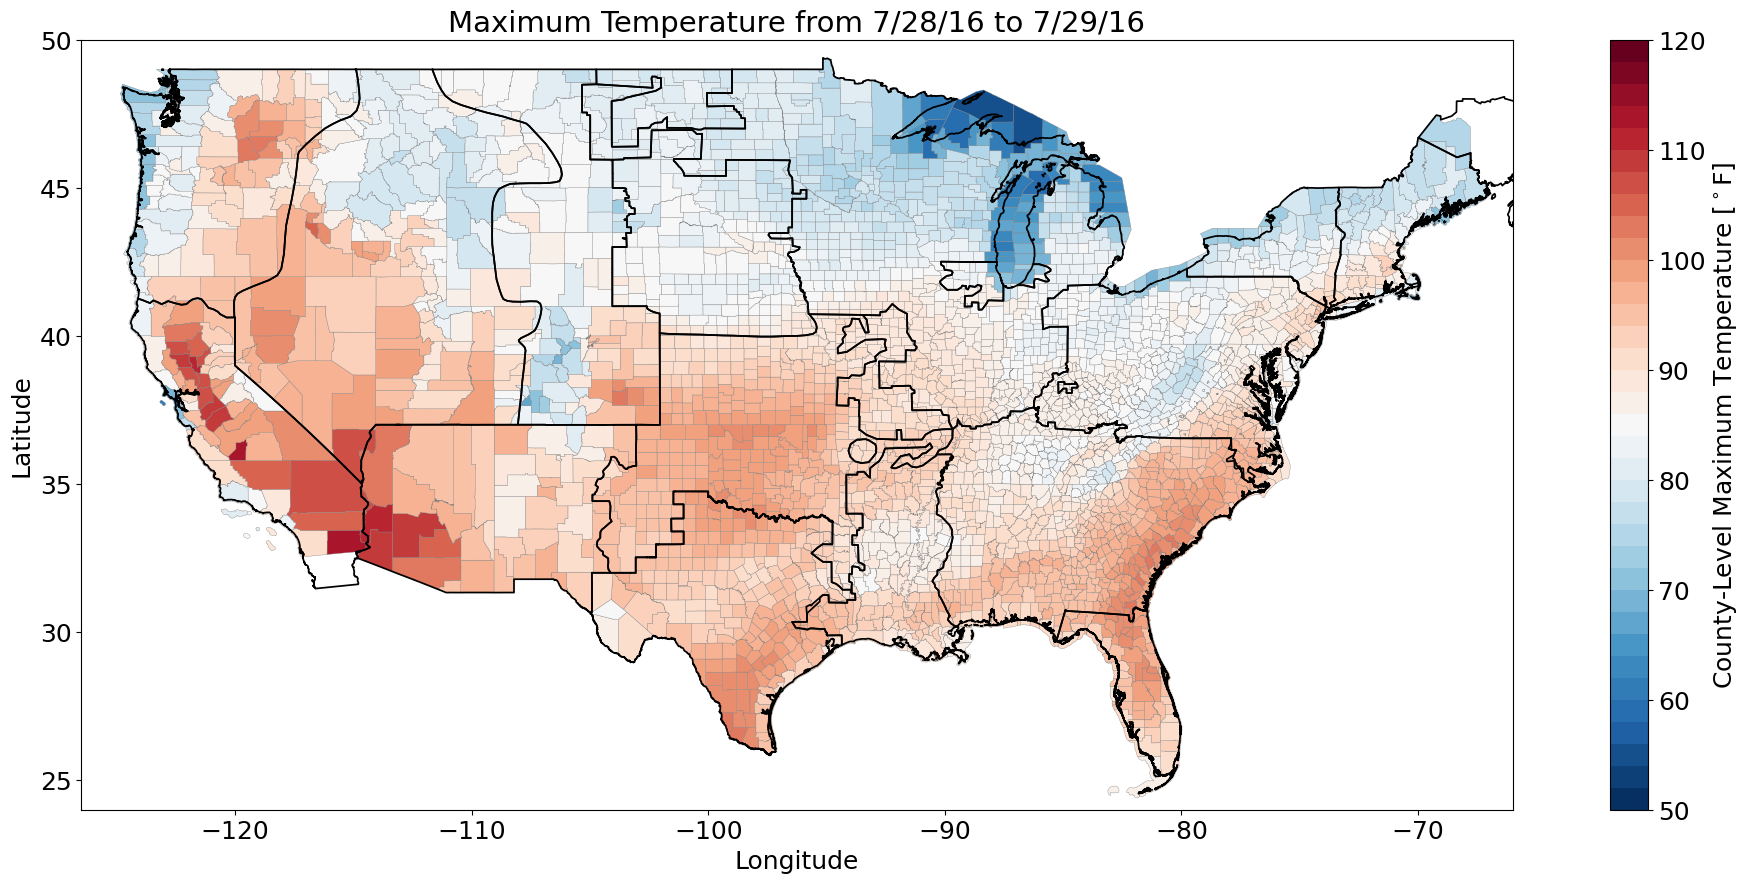

In [22]:
# Make the plot
plot_county_temperature_map(hw_cs = 'HW',
                            event = 'HW_NERC11_Event88',
                            hw_cs_data_dir = hw_cs_data_dir,
                            nerc_shapefile_dir = nerc_shapefile_dir, 
                            county_shapefile_dir = county_shapefile_dir,
                            image_output_dir = image_output_dir, 
                            image_resolution = 150, 
                            save_images = True)
